In [1]:
# !pip install gpytorch

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
### Importing libraries and modules
import copy

from datetime import datetime
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import pandas as pd
import numpy as np
import pickle

import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.models import ApproximateGP

from torch.optim.lr_scheduler import StepLR

In [2]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25
seq_len = 3
pre_len = 1

#adjacency matrix
grid_points = pd.read_csv('../grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

In [3]:
def data_preparation(datafile, hr_start, hr_end):
    df = pd.read_csv(datafile)
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]
    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)

    # rounding @120min
    df.dateTime = pd.to_datetime(df.dateTime)
    # df.dateTime = df.dateTime.dt.round('180min')
    df = df[['lat_grid','long_grid', 'dateTime', 'pm2_5']]
    df = df[df.dateTime.dt.hour>=hr_start]
    df = df[df.dateTime.dt.hour<hr_end]
    
    df = df[["lat_grid", "long_grid", "pm2_5"]]
    df = df.groupby(['lat_grid', 'long_grid']).mean().reset_index()
    # df['dateTime'] = df.dateTime.apply(lambda x: x.timestamp())
    # df = df.groupby(['lat_grid','long_grid', 'dateTime']).mean()
    # df = df.sort_values("dateTime")
    df = df.reset_index()  
    return df

In [4]:
def plot_predictions(test_output, test_true, save_path=None):
    ##all test result visualization
    fig = plt.figure(figsize=(15, 8))
    # test_output, test_true = eval(model, testX, testY )
    a_pred = test_output[test_true>0]
    a_true = test_true[test_true>0]
    plt.plot(a_pred, "r-", label="prediction")
    plt.plot(a_true, "b-", label="true")
    plt.xlabel("test points")
    plt.ylabel("PM2.5")
    plt.legend(loc="best", fontsize=10)
    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

In [6]:
def get_kernel(kernel = 0, ard = None):
    """
    Returns the kernel accroding to the index given as an argument
    Ard here allows us to fit a separate lengthscale to each dimension/features. Lengthscale is one of the hyperparameters that 
    learn for the kernel function.
    """
    if kernel == 0:
        return gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims = ard))
    elif kernel == 1:
        return gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 0.5, ard_num_dims = ard))
    elif kernel == 2:
        return gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 1.5, ard_num_dims = ard))
    elif kernel == 3:
        return gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 2.5, ard_num_dims = ard))
    elif kernel == 4:
        k1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(active_dims = [2]))
        k2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 0.5, active_dims = [0,1,2]))
        return gpytorch.kernels.AdditiveKernel(k1, k2)
    elif kernel == 5: ### not good results
        k1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(active_dims = [2], period_length_prior = \
                                                                         gpytorch.priors.NormalPrior(40000, 1)))
        k2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 0.5, active_dims = [0,1,2]))
        return gpytorch.kernels.AdditiveKernel(k1, k2)
    elif kernel == 6:
        # time
        k1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(active_dims = [2]))
        k2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 1.5, active_dims = [2]))
        k12 = gpytorch.kernels.AdditiveKernel(k1, k2)
        # long
        k3 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(active_dims = [1]))
        k4 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 0.5, active_dims = [1]))
        k34 = gpytorch.kernels.ProductKernel(k3, k4)
        # lat
        k5 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 0.5, active_dims = [0]))
        return gpytorch.kernels.ProductKernel(k12, k34, k5)
    elif kernel == 7: ### not good results
        k1 =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 0.5, ard_num_dims = ard))
        k2 =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 1.5, ard_num_dims = ard))
        k3 =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 2.5, ard_num_dims = ard))
        return gpytorch.kernels.AdditiveKernel(k1, k2, k3)
        
def get_mean(mean = 0, n_features = 0):
    """
    Returns the mean function according to the index given as an argument
    """
    if mean == 0:
        return gpytorch.means.ConstantMean()
    elif mean == 1:
        return gpytorch.means.LinearMean(n_features)
    
class GPModel(ApproximateGP):
    """
    Main gp class. Uses variational inference to approximate and optimize the loss function.
    """
    def __init__(self, inducing_points, mean, n_features, kernel, ard):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = get_mean(mean, n_features = inducing_points.size(1))
        self.covar_module = get_kernel(kernel, ard)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# ------------------------------------------------------
# helper functions
def create_loaders(t_tuple, tuple = True):
    """
    Creates dataloaders to load in minibatches during training and testing
    """
    if tuple:
      x, y = t_tuple
      dataset = TensorDataset(x, y)
    else:
      x = t_tuple
      dataset = TensorDataset(x)
    loader = DataLoader(dataset, batch_size=1024, shuffle=False)
    
    return loader

def m_s_adjust(x):
    """
    Adjusts for mean and std for input/output normalization. Used in the next function.
    
    || INPUT ||
    x - dataset to standardize 
    
    || OUTPUT ||
    x - transformed dataset
    mx - mean of original dataset
    sx - std of original dataset
    """
    x = x.clone()
    mx = x.mean(0, keepdim=True)
    sx = x.std(0, unbiased=False, keepdim=True)
    x -= mx
    x /= sx
    return x, mx, sx

def normalize(train_tuple, test_tuple = None):
    """
    Normalize the train and/or test datasets
    
    || INPUT ||
    train_tuple - (train features, train output variable) 
    test_tuple - (test features, test output variable) 
    
    || OUTPUT ||
    outputs transformed train and test tuples (tuples as defined above) along with learnt mean and std. deviations
    """
    train_x, train_y = train_tuple
    train_x, train_y  = train_x.clone(), train_y.clone() 
    
    train_x, mx, sx = m_s_adjust(train_x)
    train_y, my, sy = m_s_adjust(train_y)
    train_tuple = (train_x, train_y)
    
    if test_tuple:
        test_x, test_y = test_tuple
        test_x, test_y  = test_x.clone(), test_y.clone() 
        test_x -= mx
        test_x /= sx
        test_y -= my
        test_y /= sy
        test_tuple = (test_x, test_y)
    return train_tuple, test_tuple, (mx, sx), (my, sy)

def keep_best(prev_train, prev_test, train_rmse, test_rmse):
    """
    This function helps us keep the best model learnt till now. It checks how current train and test rmse are compared to 
    previous iterations train and test rmse. Returns True if both are lower than previous.  
    """
    if train_rmse <= prev_train:
        if test_rmse <= prev_test:
            result = True
        else:
            result = False
    else:
        result = False
    return result
    
def train_gp(model, likelihood, train_tuple, loader, optimizer, mll, cuda = False):
    """
    Trains the Gaussian Process model
    """
    model.train()
    likelihood.train()
    minibatch_iter = tqdm.tqdm_notebook(loader, desc="Minibatch", leave=False)
    mean_loss = 0
    count = 0 
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        mean_loss += loss.item()
        count+=1
        loss.backward()
        optimizer.step()
        if cuda:
            torch.cuda.empty_cache()
    
    print("Mean Loss:", mean_loss/count)
    return model, optimizer, mll

def fit_model(data_tuple, num_epochs, ind_pts = 100, cuda = False, normalizer = False, kernel = 0, mean = 0, ard = None):
    """
    Fits the model. Uses all the above functions to fit the model in a customized way. 
    """
    # forming needed tuples
    train_x, train_y, test_x, test_y = data_tuple      
    train_tuple = train_x, train_y
    test_tuple = test_x, test_y
    
    # normalizing
    if normalizer:
        train_tuple, test_tuple, x_ms, y_ms = normalize(train_tuple, test_tuple)
        train_x, train_y = train_tuple
        test_x, test_y = test_tuple
    else:
        x_ms = (0,1)
        y_ms = (0, 1)
     
    ms = (x_ms, y_ms)
        
    # gaussian likelihood is part of our model definition and tells us about the pure error term
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    
    # model and inducing points
    inducing_idx = np.linspace(0, train_x.shape[0]-1, ind_pts) # selects the inducing points in such a way that they are spread
                                                                # equally throughout the dataset
    inducing_points = train_x[inducing_idx, :]
    model = GPModel(inducing_points, mean = mean, n_features = 0, kernel = kernel, ard = ard)
       
    # transfer everything to GPU if needed
    if cuda:
        model = model.cuda()
        likelihood = likelihood.cuda()
        train_x = train_x.cuda()
        train_y = train_y.cuda()
        test_x = test_x.cuda()
        test_y = test_y.cuda()
     
    # form tuples again as depending on "cuda" they might have been transferred to GPU
    train_tuple = (train_x, train_y)
    test_tuple = (test_x, test_y)
    
    # form loaders that allow us to train the data using batches. 
    train_loader = create_loaders(train_tuple)
    test_loader = create_loaders(test_tuple)
  
    # loss and optimizer both have changed a little
    # optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.08)
    optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': likelihood.parameters()}], lr=0.08)
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))    
    
    # main chunk of code. Goes through multiple epochs 
    epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
    prev_train = np.inf # these are to aid us in the selection of the best model
    prev_test = np.inf
    best_model = None
    best_likelihood = None
    scheduler = StepLR(optimizer, step_size=15, gamma=0.1) # this decreases the learning rate with epochs

    likelihood.noise_covar.noise = 0.01

    for i in epochs_iter:
        print("Epoch:", i)
        
        # training the model
        model, optimizer, mll = train_gp(model, likelihood, (train_x, train_y), train_loader, optimizer, mll, cuda)
        
        # evaluating on train and validation/test set
        train_rmse, train_means, train_lower, train_upper = evaluate(model, train_loader, train_y, likelihood, y_ms, cuda)
        test_rmse, test_means, test_lower, test_upper = evaluate(model, test_loader, test_y, likelihood, y_ms, cuda)
        print('Train RMSE: {}'.format(train_rmse.item()))
        print('Test RMSE: {}'.format(test_rmse.item()))
        print("Noise: {}".format(likelihood.noise_covar.noise.detach().item()))
        
        # saving best model
        model_best = keep_best(prev_train, prev_test, train_rmse, test_rmse)
        if model_best == True:
            best_model = copy.deepcopy(model)
            best_likelihood = copy.deepcopy(likelihood)
        prev_train = train_rmse
        prev_test = test_rmse
        scheduler.step()

    return (train_means, train_lower, train_upper), (test_means, test_lower, test_upper), (best_model, best_likelihood), \
            (model, likelihood), ms, train_rmse

def evaluate(model, loader, y, likelihood, y_ms, cuda):
    """
    Evaluates the model on the given loader and y using rmse
    """
    model.eval()
    likelihood.eval()
    
    means = torch.tensor([0.])
    lower_conf = torch.tensor([0.])
    upper_conf = torch.tensor([0.])

    with torch.no_grad():
        for x_batch, y_batch in loader:
            preds = model(x_batch)
            means = torch.cat([means, preds.mean.cpu()])
            lower, upper = preds.confidence_region()
            lower, upper = lower.cpu(), upper.cpu()
            lower_conf = torch.cat([lower_conf, lower])
            upper_conf = torch.cat([upper_conf, upper]) 
    
    means = means[1:]
    if cuda:
        y = y.cpu()
    lower_conf = lower_conf[1:]
    upper_conf = upper_conf[1:]
    unnormalized_means = means*y_ms[1] + y_ms[0]
    lower_conf = lower_conf*y_ms[1] + y_ms[0]
    upper_conf = upper_conf*y_ms[1] + y_ms[0]
    
    prediction_error = means - y
    rmse = torch.sqrt(torch.mean(torch.square(prediction_error)))
    unnormalized_rmse = y_ms[1]*rmse
    
    return unnormalized_rmse, unnormalized_means, lower_conf, upper_conf

def eval_fresh(model, likelihood, data, ms, normalizer, cuda):
    """
    Evaluates the model on new data.
    """
    data = torch.Tensor(data.values)
    x_ms, y_ms = ms
    data = data.clone()
    if normalizer:
        data -= x_ms[0]
        data /= x_ms[1]
        
    if cuda:
        data = data.cuda()
        model = model.cuda()
        likelihood = likelihood.cuda()
        
    loader = create_loaders(data, tuple = False)
    
    model.eval()
    likelihood.eval()
    
    means = torch.tensor([0.])
    lower_conf = torch.tensor([0.])
    upper_conf = torch.tensor([0.])

    with torch.no_grad():
        for x_batch in loader:
            preds = model(x_batch[0])
            means = torch.cat([means, preds.mean.cpu()])
            lower, upper = preds.confidence_region()
            lower, upper = lower.cpu(), upper.cpu()
            lower_conf = torch.cat([lower_conf, lower])
            upper_conf = torch.cat([upper_conf, upper]) 
    
    means = means[1:]
    lower_conf = lower_conf[1:]
    upper_conf = upper_conf[1:]
    unnormalized_means = means*y_ms[1] + y_ms[0]
    lower_conf = lower_conf*y_ms[1] + y_ms[0]
    upper_conf = upper_conf*y_ms[1] + y_ms[0]
    
    return unnormalized_means, lower_conf, upper_conf


def reconstruct(sub_df, preds):
    """
    forms a dataset using the orgiginal and predicted data
    """
    cols = sub_df.columns.tolist()
    cols.extend(["means", "lc", "uc"])
    means, lower, upper = preds
    means, lower, upper = means.detach().numpy().reshape(-1,1), lower.detach().numpy().reshape(-1,1), upper.detach().numpy().reshape(-1,1)
    sub = pd.DataFrame(np.hstack([sub_df, means, lower, upper]), columns = cols)
    # sub = sub.sort_values("dateTime")
    return sub

def create_grid_df(df, n_splits = 6):
  """
  Forms a grid dataframe that contains the centroids wrt to GPS coords of the given df along with the different hours
  """
  
  df["hour"] = df.dateTime.dt.hour
  hours_unique = df.hour.unique()
  min_lat, max_lat = df.lat.min(), df.lat.max()
  min_long, max_long = df.long.min(), df.long.max()

  # regions

  lat_min=  min_lat
  lat_max = max_lat
  long_min = min_long
  long_max = max_long

  bottomLeft = (lat_min, long_min)
  bottomRight = (lat_min, long_max)
  topLeft = (lat_max, long_min)
  topRight = (lat_max, long_max)

  cols = np.linspace(bottomLeft[1], bottomRight[1], num=n_splits)
  rows = np.linspace(bottomLeft[0], topLeft[0], num=n_splits)
  centroids= np.empty(shape = (1,2))

  for i, _ in enumerate(rows):
    for j, __ in enumerate(cols):
      try:
        center_lat = (rows[i] + rows[i+1])/2 
        center_long = (cols[j] + cols[j+1])/2
        centroids = np.vstack([centroids, np.array([center_long, center_lat])])
      except IndexError:
        pass

  centroids = pd.DataFrame(centroids, columns = ["long", "lat"])
  centroids = centroids.iloc[1:,:]
  main_centroids = pd.DataFrame(np.empty(shape = (1,3)), columns =["long", "lat", "hour"])

  for hour in hours_unique:
    centroids["hour"] = hour
    main_centroids = pd.concat([main_centroids, centroids], axis = 0)

  main_centroids = main_centroids.iloc[1:,:]
  main_centroids.reset_index(drop = True, inplace = True)

  main_centroids["datetime"] = pd.to_datetime(str(df.dateTime.iloc[0].date())+" " + main_centroids.hour.astype(int).astype(str) + ":00:00").apply(lambda x: x.tz_localize("Asia/Kolkata").timestamp())
  return main_centroids

#---------------------------------------------------------------------
### Main Interpolation Function

def main_interpol(df, hour = None,cuda = True, n_splits = 6):
    """
    Main function to run interpolation with any pollution data and store final output dataframe and train RMSE in a dictionary 
    """
    main_dict = {}
    
    # selecting columns to be used
    all_cols = ["lat_grid", "long_grid", "pm2_5"] 
    x_cols = ["lat_grid", "long_grid"]
    y_cols = ["pm2_5"]
    
    # main train and valid functions
    # if hour: 
    #   df = df[df.hour == hour]
    ind_points = 50
    # else:
      # ind_points = 2100
    train = df
    # train = train.sort_values(by = "dateTime")
    sub_train = train.sample(frac = 0.9, random_state = 0)
    sub_valid = train.drop(sub_train.index)
    
    x_train, y_train = torch.Tensor(sub_train[x_cols].values), torch.Tensor(sub_train[y_cols].values.flatten())
    x_valid, y_valid = torch.Tensor(sub_valid[x_cols].values), torch.Tensor(sub_valid[y_cols].values.flatten())

    data_tuple = (x_train, y_train, x_valid, y_valid)
    
    train_preds, valid_preds, best_model, curr_model, ms, rmse  = fit_model(data_tuple, 30, ind_points, normalizer = True, \
                                                                            kernel = 1, cuda= cuda, ard = 2)

#     plot_this = reconstruct(sub_train[["dateTime", "pm2_5"]], train_preds)
    
#     # get grid based predictions
#     grid_df = create_grid_df(sub_train, n_splits)
#     grid_means, grid_lower, grid_upper = eval_fresh(best_model[0], best_model[1], grid_df[x_cols], ms, True, cuda)
#     grid_plot_this = reconstruct(grid_df, (grid_means, grid_lower, grid_upper))
    
#     main_dict["df"] = plot_this
#     main_dict["grid_df"] = grid_plot_this
#     main_dict["train_rmse"] = rmse
#     print("----------------------*----------------------")
    return main_dict, best_model

In [7]:
df = data_preparation('../PM Datasets/2021-01-30_all.csv', 16, 19)
# df
main_dict= {}
# main_dict, final_model = main_interpol(df, cuda = True, n_splits = 10, hour = 17)

In [8]:
main_dict, final_model = main_interpol(df, cuda = True, n_splits = 10, hour = 17)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0


Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

output
<class 'gpytorch.distributions.multivariate_normal.MultivariateNormal'>


AttributeError: 'MultivariateNormal' object has no attribute 'shape'

Text(0.5, 1.0, 'Mean Predictions for chosen Hour')

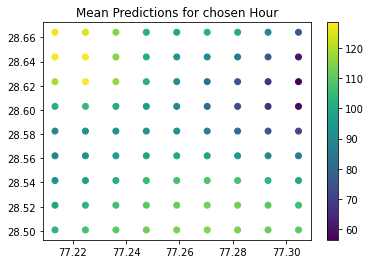

In [ ]:
hour_to_show = 17
sub = main_dict["grid_df"][main_dict["grid_df"].hour == hour_to_show]
plt.scatter(sub.long, sub.lat, c = sub.means)
plt.colorbar()
plt.title("Mean Predictions for chosen Hour")

Text(0.5, 1.0, 'Training Fit')

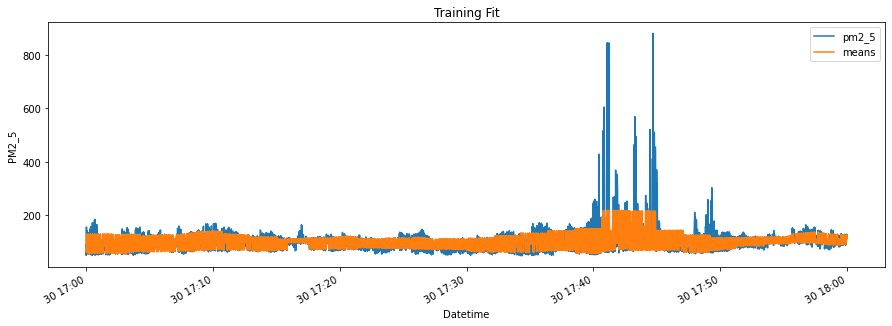

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), sharey = True)
main_dict["df"].set_index("dateTime")[["pm2_5", "means"]].plot(ax = ax)
ax.set_title("Train")
ax.set_xlabel("Datetime")
ax.set_ylabel("PM2_5")
plt.title("Training Fit")

Rough